# Total AF prediction

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

output_folder = './validation_report/Total_AF'
today = pd.Timestamp.today().strftime('%Y-%m-%d')

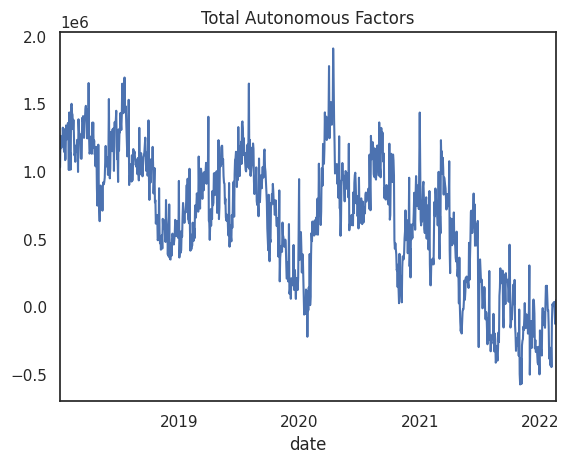

In [14]:
CIC = pd.read_excel('../data/CIC.xlsx', parse_dates=['date'], index_col='date')
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')
SAB = pd.read_excel('../data/SAB.xlsx', parse_dates=['date'], index_col='date')
data = pd.concat([CIC, NFA, SAB], axis=1)
data['Total'] = data['NFA'] - data['CIC'] - data['SAB']
data['Total'].plot(title = 'Total Autonomous Factors'); plt.show()

## Section 2: Model Definition

In [15]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS,
)

ForecastingModels = {
    "Naive": NaiveForecaster(strategy = 'drift'),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=True, seasonal=True),
    "AutoETS": StatsForecastAutoETS(season_length=1),
    "AutoCES": StatsForecastAutoCES(season_length=1),
    "AutoTheta": StatsForecastAutoTheta(season_length=1),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=1, use_trend =True, use_boxcox=True),
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'Total',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


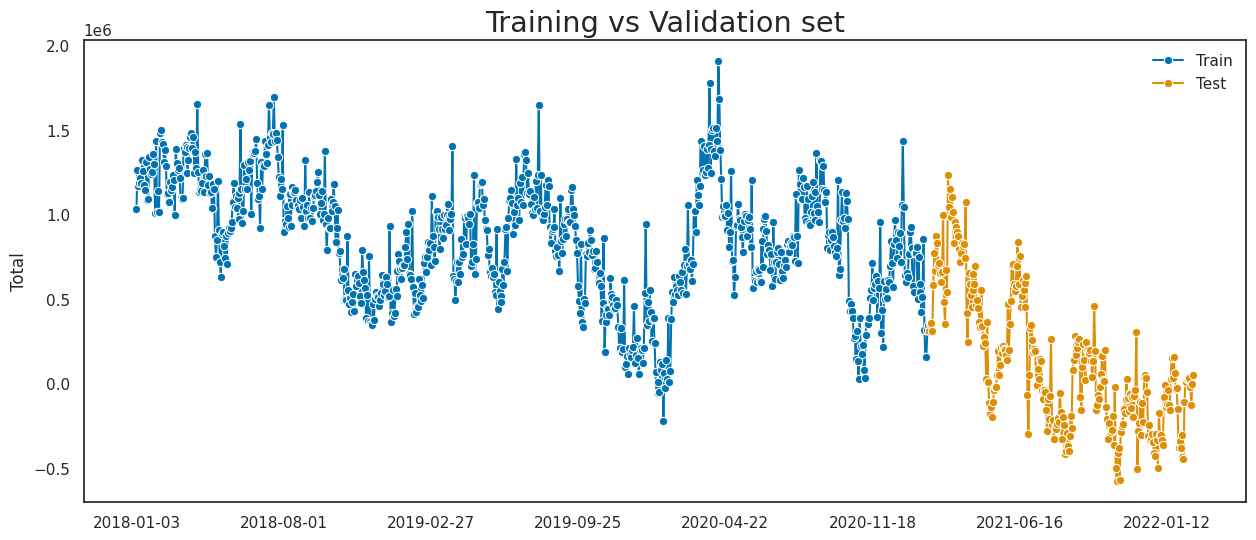

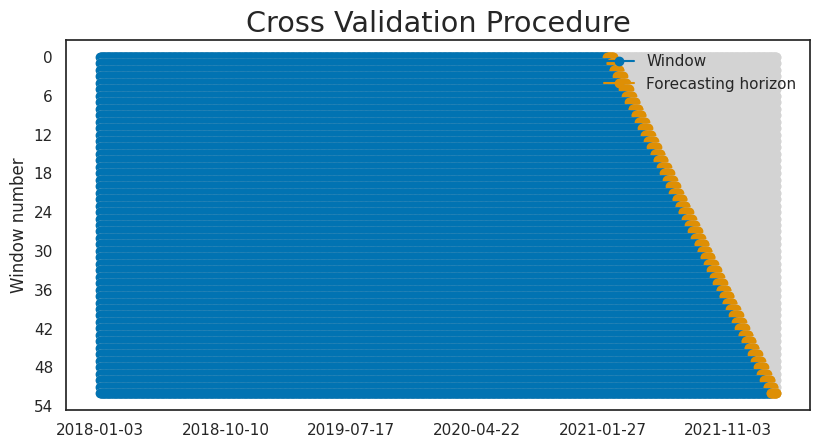

In [16]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')
plt.savefig(os.path.join(output_folder, f'train_test_{today}.png'), dpi=300)

model.plot_cv_procedure(xlabel='')
plt.savefig(os.path.join(output_folder, f'cross_validation_{today}.png'), dpi=300)

### Out-Of-sample Evaluation

In [17]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 272.11it/s]


Evaluation completed in: 0 seconds
Fitting the model Naive on the entire sample ...
Model fitted in 0 seconds

Start AutoARIMA forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 143.67it/s]


Evaluation completed in: 0 seconds
Fitting the model AutoARIMA on the entire sample ...
Model fitted in 0 seconds

Start AutoETS forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 289.21it/s]


Evaluation completed in: 0 seconds
Fitting the model AutoETS on the entire sample ...
Model fitted in 0 seconds

Start AutoCES forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 192.62it/s]


Evaluation completed in: 0 seconds
Fitting the model AutoCES on the entire sample ...
Model fitted in 0 seconds

Start AutoTheta forecaster evaluation....


100%|██████████| 51/51 [00:03<00:00, 14.82it/s]


Evaluation completed in: 4 seconds
Fitting the model AutoTheta on the entire sample ...
Model fitted in 1 seconds

Start AutoTBATS forecaster evaluation....


100%|██████████| 51/51 [00:04<00:00, 11.54it/s]


Evaluation completed in: 6 seconds
Fitting the model AutoTBATS on the entire sample ...
Model fitted in 0 seconds


In [18]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Number of Predictions,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoCES,51,312,0.037546,0.009084,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,258491.153275,225214.15125,2.135111,-3.337345,215351.574249
AutoARIMA,51,312,0.144505,0.008456,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,262267.392911,228777.969834,2.199086,-3.514324,218650.746052
AutoTheta,51,312,2.2995,0.008182,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,262270.434433,228558.428908,2.206773,-3.509626,218164.774962
AutoETS,51,312,0.044102,0.005542,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,262808.649953,229148.478446,2.219213,-3.500739,219006.208358
AutoTBATS,51,312,1.667902,0.007179,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,261931.457711,228426.659687,2.258016,-3.357794,217595.533945
Naive,51,312,0.004809,0.007921,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,252096.348536,217912.733494,2.302959,-3.462806,207543.662818


horizon                        1              2              3   \
Naive     RMSE      208180.759208  226992.059181  242366.584736   
          MAE       148391.933232  168609.292488  187133.060888   
          MAPE           1.347276       1.668562       1.815251   
          R2             0.728066       0.673739       0.620702   
          MedianAE  106676.539966  123250.350277  151821.338263   
AutoARIMA RMSE      226052.312130  241638.655787  255707.342708   
          MAE       175147.697260  191025.922949  203247.262381   
          MAPE           1.606293       1.899204       1.828378   
          R2             0.679373       0.630277       0.577797   
          MedianAE  138245.989254  155124.347228  173526.350250   
AutoETS   RMSE      226569.855618  242123.523325  256207.624405   
          MAE       175545.969543  191369.513169  203810.662973   
          MAPE           1.612003       1.903221       1.840167   
          R2             0.677903       0.628792       0.576144   
          MedianAE  136002.783627  153683.409425  172309.048790   
AutoCES   RMSE      225487.555143  240425.727320  253782.089369   
          MAE       174334.957457  189327.766551  200890.348958   
          MAPE           1.588576       1.867331       1.793821   
          R2             0.680973       0.633979       0.584131   
          MedianAE  137225.460938  148900.593750  169254.503906   
AutoTheta RMSE      226578.806507  242077.850239  256157.912399   
          MAE       175607.407565  191401.207225  203731.534918   
          MAPE           1.614109       1.904978       1.841220   
          R2             0.677878       0.628932       0.576308   
          MedianAE  134576.386719  156790.226562  170668.070312   
AutoTBATS RMSE      224363.879310  240169.117981  253858.450211   
          MAE       172487.348978  189563.220407  203126.710424   
          MAPE           1.584837       1.899722       1.826119   
          R2             0.684145       0.634760       0.583881   
          MedianAE  134446.644535  163356.515627  175752.769234   

horizon                        4              5              6   \
Naive     RMSE      256836.785830  268785.930675  284950.183326   
          MAE       201444.238731  217438.736222  233892.938763   
          MAPE           2.024422       2.165254       2.507170   
          R2             0.582419       0.536991       0.489682   
          MedianAE  166351.585211  183971.484006  211968.774998   
AutoARIMA RMSE      264766.205383  277784.822610  290207.516772   
          MAE       214855.455932  227541.607777  239388.991592   
          MAPE           1.930333       2.071584       2.236125   
          R2             0.556236       0.505470       0.470677   
          MedianAE  186490.272186  211993.145758  219319.655349   
AutoETS   RMSE      265205.881947  278129.412835  290244.801084   
          MAE       215378.680611  227896.705218  239722.509703   
          MAPE           1.942137       2.080857       2.250164   
          R2             0.554761       0.504242       0.470541   
          MedianAE  185277.920052  212349.026185  223550.341849   
AutoCES   RMSE      262263.494048  274387.082544  286001.782456   
          MAE       211978.906901  223943.076410  235257.979680   
          MAPE           1.884060       2.009952       2.163760   
          R2             0.564586       0.517493       0.485908   
          MedianAE  186573.574219  204277.240234  215120.414062   
AutoTheta RMSE      265160.190928  278073.635145  290290.569670   
          MAE       215224.773494  227488.727508  239166.034136   
          MAPE           1.940852       2.075661       2.238645   
          R2             0.554915       0.504441       0.470374   
          MedianAE  183635.435547  213086.437500  219695.171875   
AutoTBATS RMSE      263023.592374  275039.053167  286238.921660   
          MAE       215808.126075  229363.215710  239794.135410   
          MAPE           1.972176       2.1631

In [19]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,Naive,Naive,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES,Naive,AutoCES,AutoCES
Best_2,AutoTBATS,AutoCES,Naive,AutoARIMA,AutoARIMA,AutoARIMA,AutoTheta,AutoCES,AutoARIMA,AutoARIMA
Best_3,AutoCES,AutoARIMA,AutoTBATS,AutoTheta,AutoTheta,AutoTheta,AutoARIMA,AutoARIMA,AutoTheta,AutoTheta
Best_4,AutoARIMA,AutoTBATS,AutoARIMA,AutoETS,AutoETS,AutoETS,AutoETS,AutoTheta,AutoETS,AutoETS
Best_5,AutoETS,AutoETS,AutoETS,AutoTBATS,AutoTBATS,AutoTBATS,Naive,AutoETS,AutoTBATS,AutoTBATS
Best_6,AutoTheta,AutoTheta,AutoTheta,Naive,Naive,Naive,AutoTBATS,AutoTBATS,Naive,Naive


,Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,
1,1.347276,1.606293,1.612003,1.588576,1.614109,1.584837,1.588576,1.347276,1.597434,1.466056,1.558849
2,1.668562,1.899204,1.903221,1.867331,1.904978,1.899722,1.867331,1.668562,1.883267,1.767946,1.857170
3,1.815251,1.828378,1.840167,1.793821,1.841220,1.826119,1.793821,1.793821,1.811100,1.804536,1.824159
4,2.024422,1.930333,1.942137,1.884060,1.940852,1.972176,1.884060,1.884060,1.907197,1.907197,1.948997
5,2.165254,2.071584,2.080857,2.009952,2.075661,2.163149,2.009952,2.009952,2.040768,2.040768,2.094409
6,2.507170,2.236125,2.250164,2.163760,2.238645,2.362788,2.163760,2.163760,2.199942,2.199942,2.293109
7,2.657357,2.626958,2.639257,2.528706,2.625455,2.724365,2.528706,2.528706,2.577832,2.577081,2.633683
8,2.357545,2.496035,2.511664,2.396700,2.497116,2.541386,2.396700,2.357545,2.446368,2.377122,2.466741
9,2.827867,2.645134,2.685618,2.551515,2.653620,2.748535,2.551515,2.551515,2.598325,2.598325,2.685382


In [20]:
# export all the result in excel 
with pd.ExcelWriter(os.path.join(output_folder, f'Cross_validation_result_{today}.xlsx')) as writer:
    summary_results.to_excel(writer, sheet_name='summary_results', index=True)
    summary_horizon.to_excel(writer, sheet_name='summary_horizon', index=True)
    rank.to_excel(writer, sheet_name='rank', index=True)
    score.to_excel(writer, sheet_name='score', index=True)

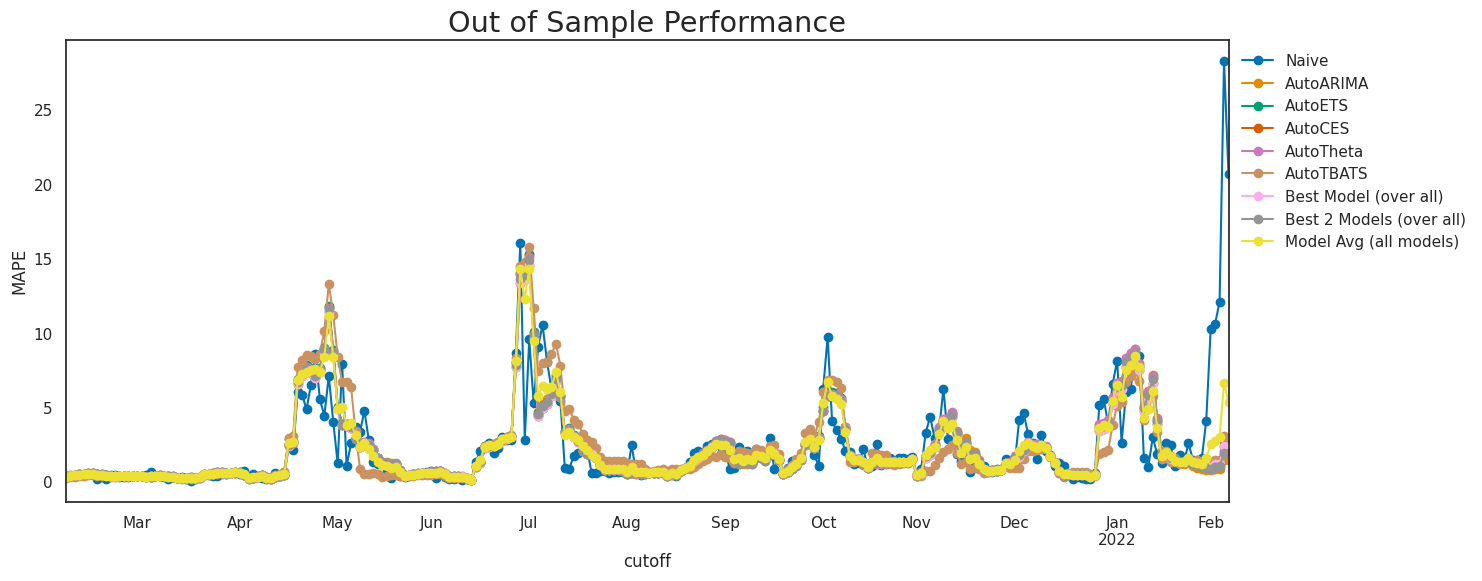

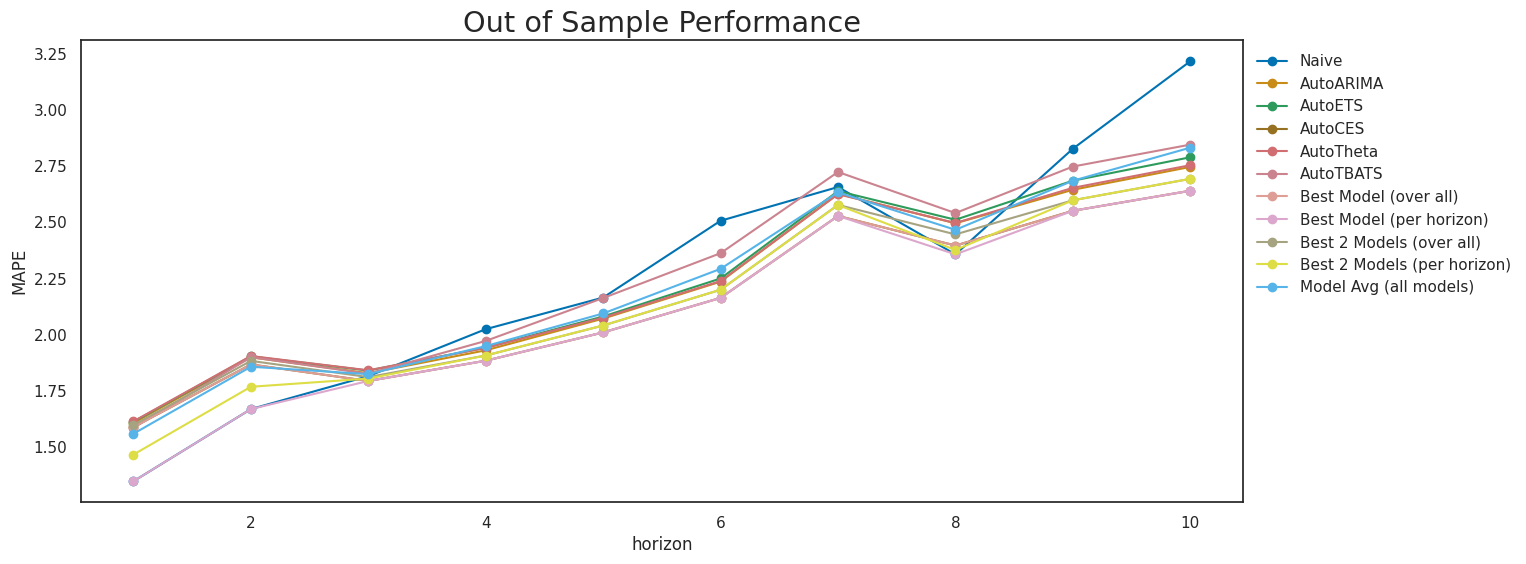

In [21]:
subset = ['AutoETS', 'AutoCES', 'AutoTBATS', 'Prophet','Model Avg (all models)']
model.plot_model_compare(score ='MAPE', view = 'cutoff')#, model_subset=subset)
plt.savefig(os.path.join(output_folder, f'model_compare_per_cutoff_{today}.png'), dpi=300, bbox_inches='tight')
model.plot_model_compare(score ='MAPE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])
plt.savefig(os.path.join(output_folder, f'model_compare_per_horizon_{today}.png'), dpi=300, bbox_inches='tight')

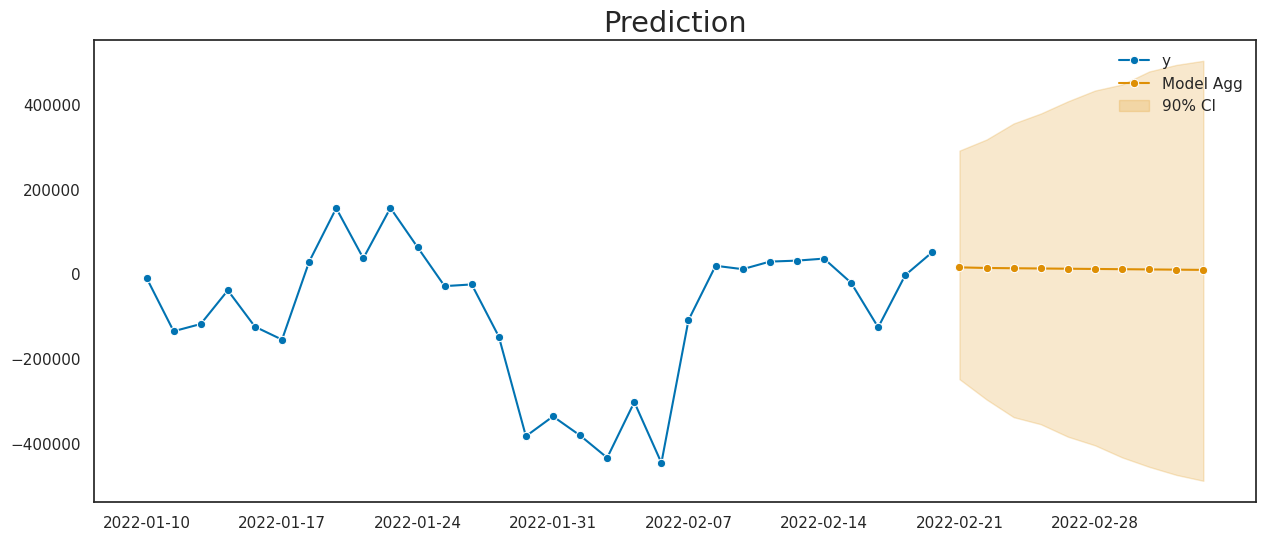

In [22]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='average', ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = None,
                     y_pred_interval = y_pred_ints)  

In [23]:
path = '../model_output/Total_AF_forecast.pkl'
model.save(path)